In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import json
import numpy as np
import scipy as sp
import scipy.stats as st
import scipy.integrate as integrate
from sklearn import linear_model

sns.set_style("whitegrid")
sns.set_palette("colorblind")
palette = sns.color_palette()
sns_colors = sns.color_palette()
figsize = (15,8)
legend_fontsize = 16

from matplotlib import rc
rc('font',**{'family':'sans-serif'})
rc('text', usetex=True)
rc('text.latex',preamble=r'\usepackage[utf8]{inputenc}')
rc('text.latex',preamble=r'\usepackage[russian]{babel}')
rc('figure', **{'dpi': 300})

## Эмпирический метод Байеса

In [5]:
## Оверфиттинг
## Исходная функция
orig = lambda x : np.sin(2*x)

## X-координаты точек данных
xd = np.arange(-1.5, 2, 7/60)
num_points = len(xd)

## Данные
data = orig(xd) + np.random.normal(0, .25, num_points)

## Для рисования
xs = np.arange(xd[0]-1.5, xd[-1]+1.5, 0.01)

## Обучаем модель с регуляризацией
def train_model(xs, ys, alpha=0, use_lasso=False):
    if alpha == 0:
        return linear_model.LinearRegression(fit_intercept=True).fit( xs, ys )
    else:
        if use_lasso:
            return linear_model.Lasso(alpha=alpha, fit_intercept=True).fit( xs, ys )
        else:
            return linear_model.Ridge(alpha=alpha, fit_intercept=True).fit( xs, ys )

[0.39729902]
[ 0.5199798 -0.321083 ]
[ 1.46911849 -0.00300612 -0.5528572 ]


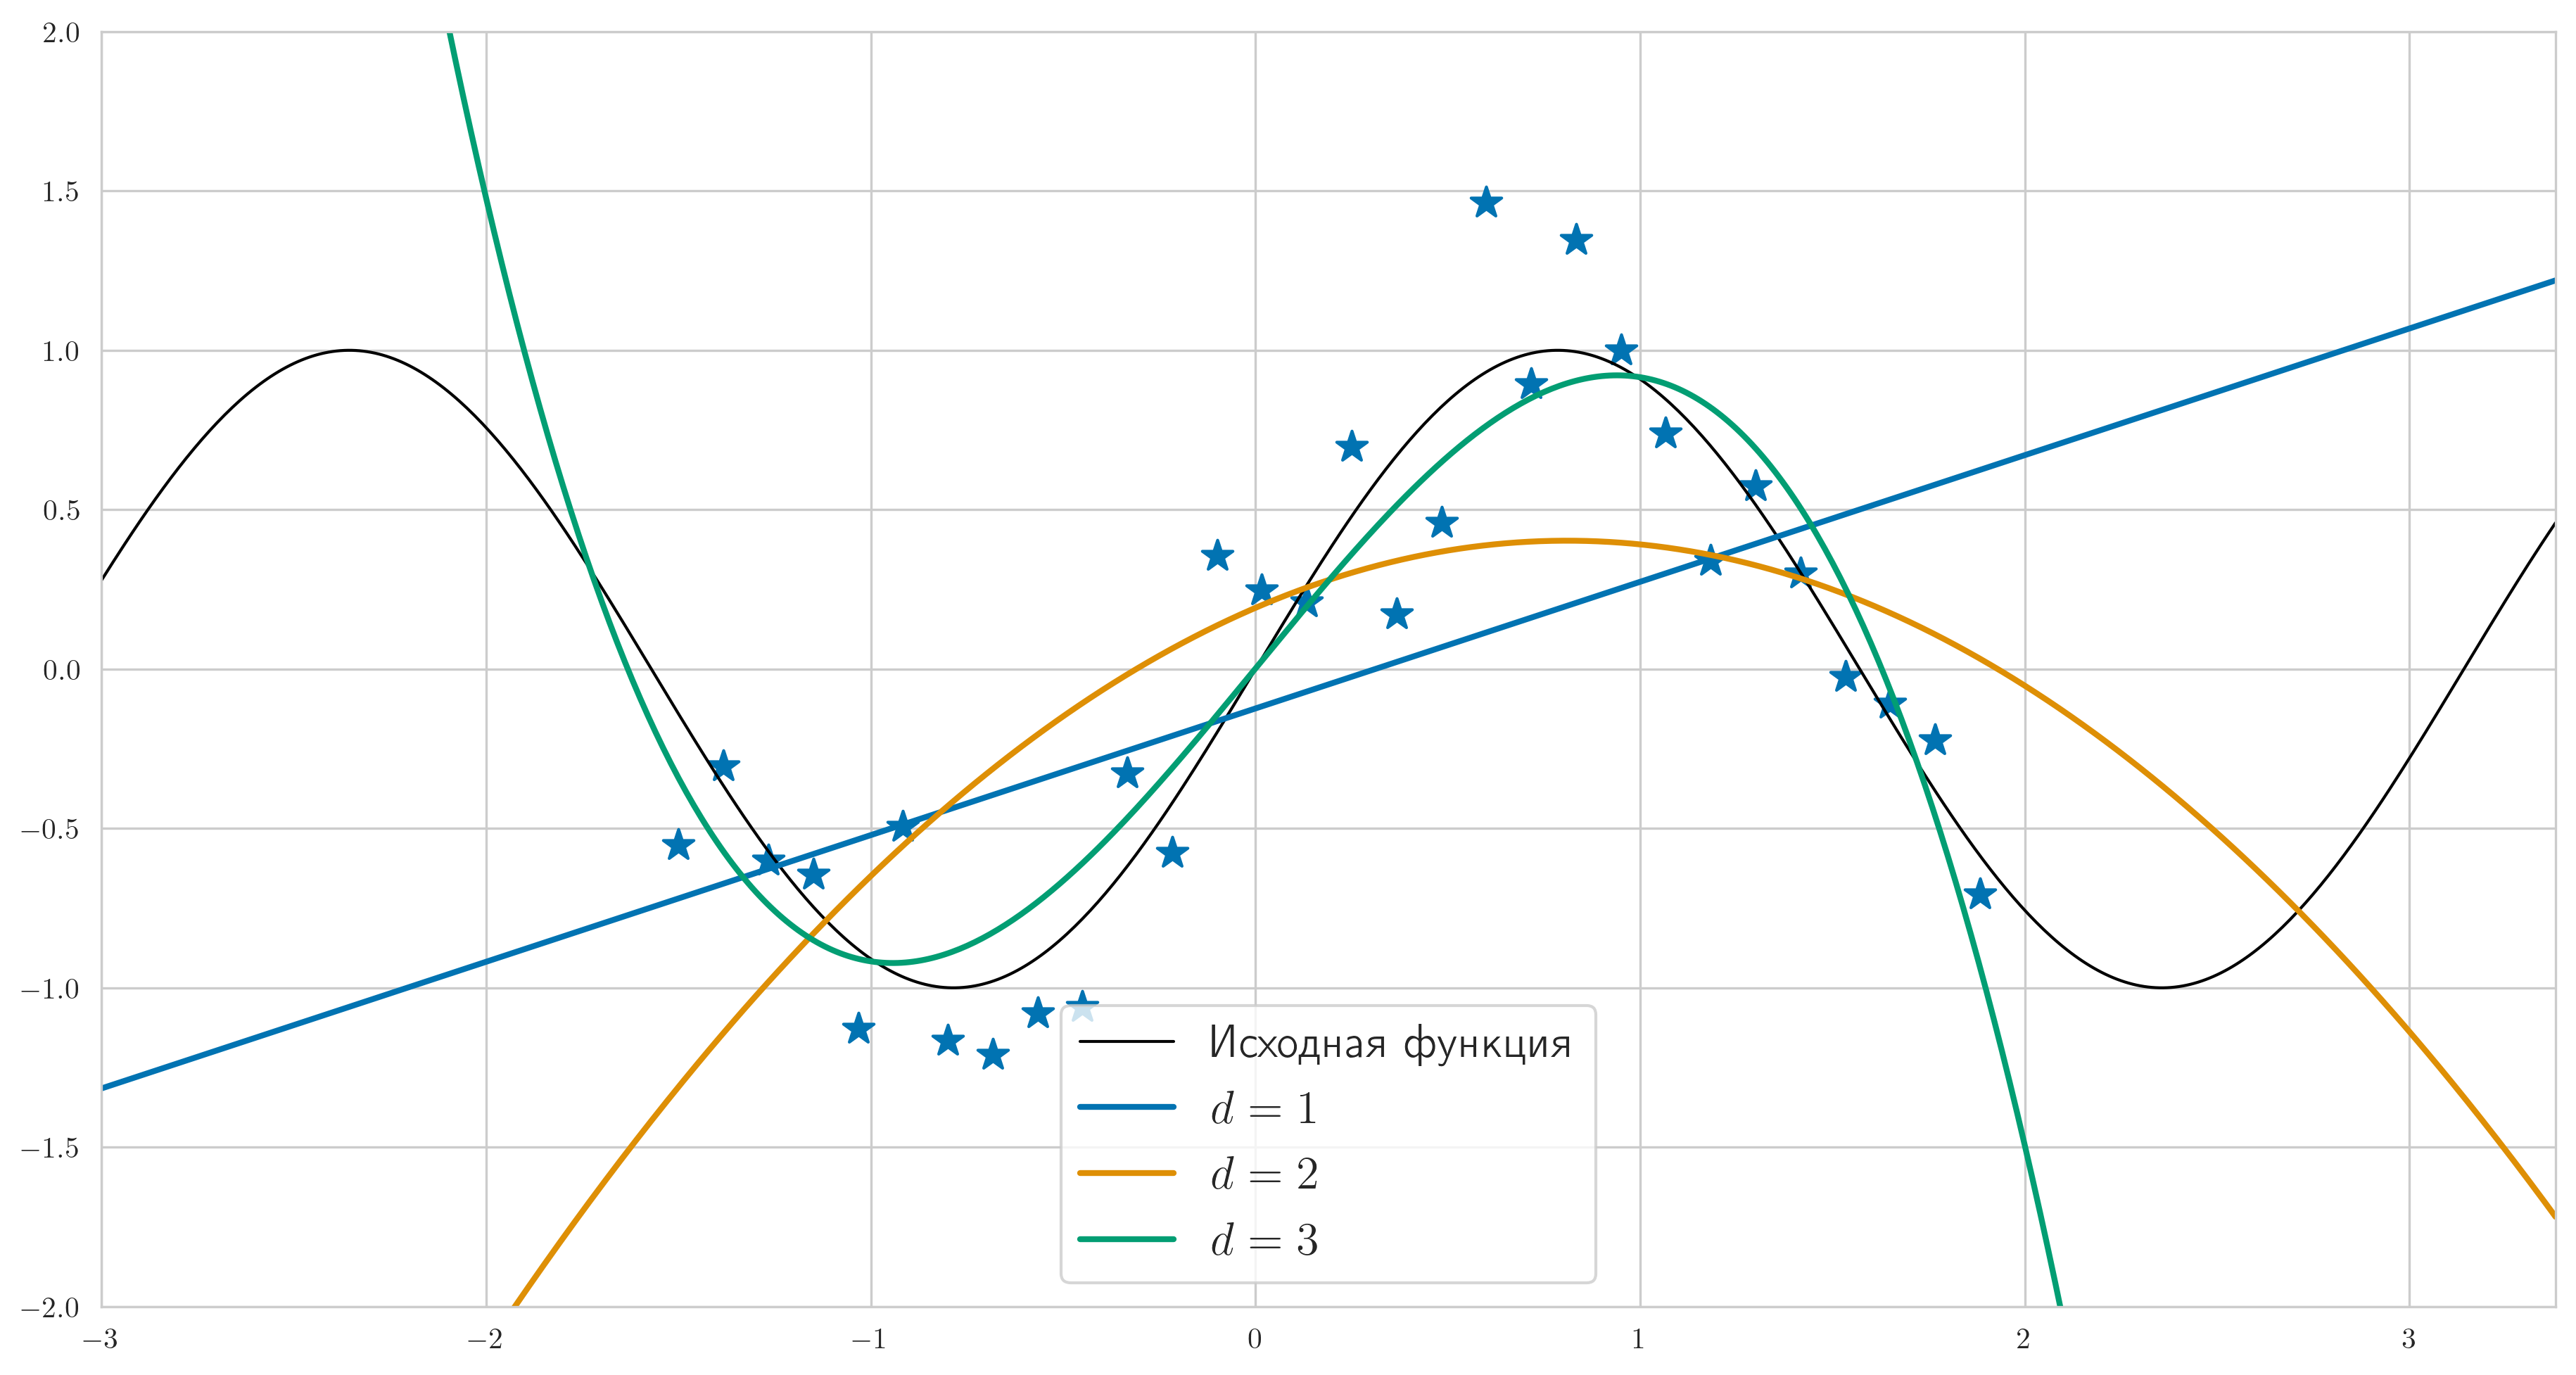

In [6]:
## Выделение полиномиальных признаков
xs_d = np.vstack([xs ** i for i in range(1, num_points+1)]).transpose()
xd_d = np.vstack([xd ** i for i in range(1, num_points+1)]).transpose()

## Какие степени многочлена будем обучать и рисовать
set_of_powers = [ 1, 2, 3 ]

fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)
ax.set_xlim((xs[0], xs[-1]))
ax.set_ylim((-2, 2))
ax.scatter(xd, data, marker='*', s=120)
ax.plot(xs, orig(xs), linewidth=1, label="Исходная функция", color="black")

for d in set_of_powers:
    if d == 0:
        print(np.mean(data))
        ax.hlines(np.mean(data), xmin=xs[0], xmax=xs[-1], label="$d=0$", linestyle="dashed")
    else:
        cur_model = train_model( xd_d[:, :d], data, alpha=0.1 )
        print(cur_model.coef_)
        ax.plot(xs, cur_model.predict( xs_d[:, :d] ), linewidth=2, label="$d=%d$" % d)

ax.legend(loc="lower center", fontsize=legend_fontsize)
# fig.savefig(output_directory + 'ms1.pdf', bbox_inches='tight')

In [7]:
def get_X(d):
    return np.hstack([np.ones(xd_d[:, :d].shape[0]).reshape(-1, 1), xd_d[:, :d]])

In [8]:
def bayesian_update(mu, Sigma, X, t, beta=4):
    Sigma_inv = np.linalg.inv(Sigma)
    Sigma_n_inv = Sigma_inv + beta * X.T.dot(X)
    Sigma_n = np.linalg.inv(Sigma_n_inv)
    mu_n = Sigma_n.dot( Sigma_inv.dot(mu.T) + beta * X.T.dot(t) )
    return mu_n, Sigma_n

In [9]:
def log_marginal_likelihood(X, t, alpha, beta):
    N, M = X.shape
    mu, sigma = bayesian_update(np.zeros(M), (1/alpha) * np.identity(M), X, t, beta=beta)
    A = np.linalg.inv(sigma)
    return 0.5 * ( M * np.log(alpha) + N * np.log(beta) - \
                  np.log(np.linalg.det(A)) - \
                  beta * np.sum((t - X.dot(mu)) ** 2) - \
                  alpha * np.sum(mu ** 2) - \
                  N * np.log(2 * np.pi) )

def lr_log_marginal(xx, t, d, alpha=0.001, beta=4):
    return log_marginal_likelihood(get_X(d), t, alpha, beta)

In [10]:
lr_evid = [ lr_log_marginal(xd_d, data, d, alpha=0.005) for d in range(1, 12)]
lr_evid2 = [ lr_log_marginal(xd_d, data, d, alpha=0.01) for d in range(1, 12)]
lr_evid3 = [ lr_log_marginal(xd_d, data, d, alpha=0.1) for d in range(1, 12)]
lr_evid4 = [ lr_log_marginal(xd_d, data, d, alpha=1) for d in range(1, 12)]

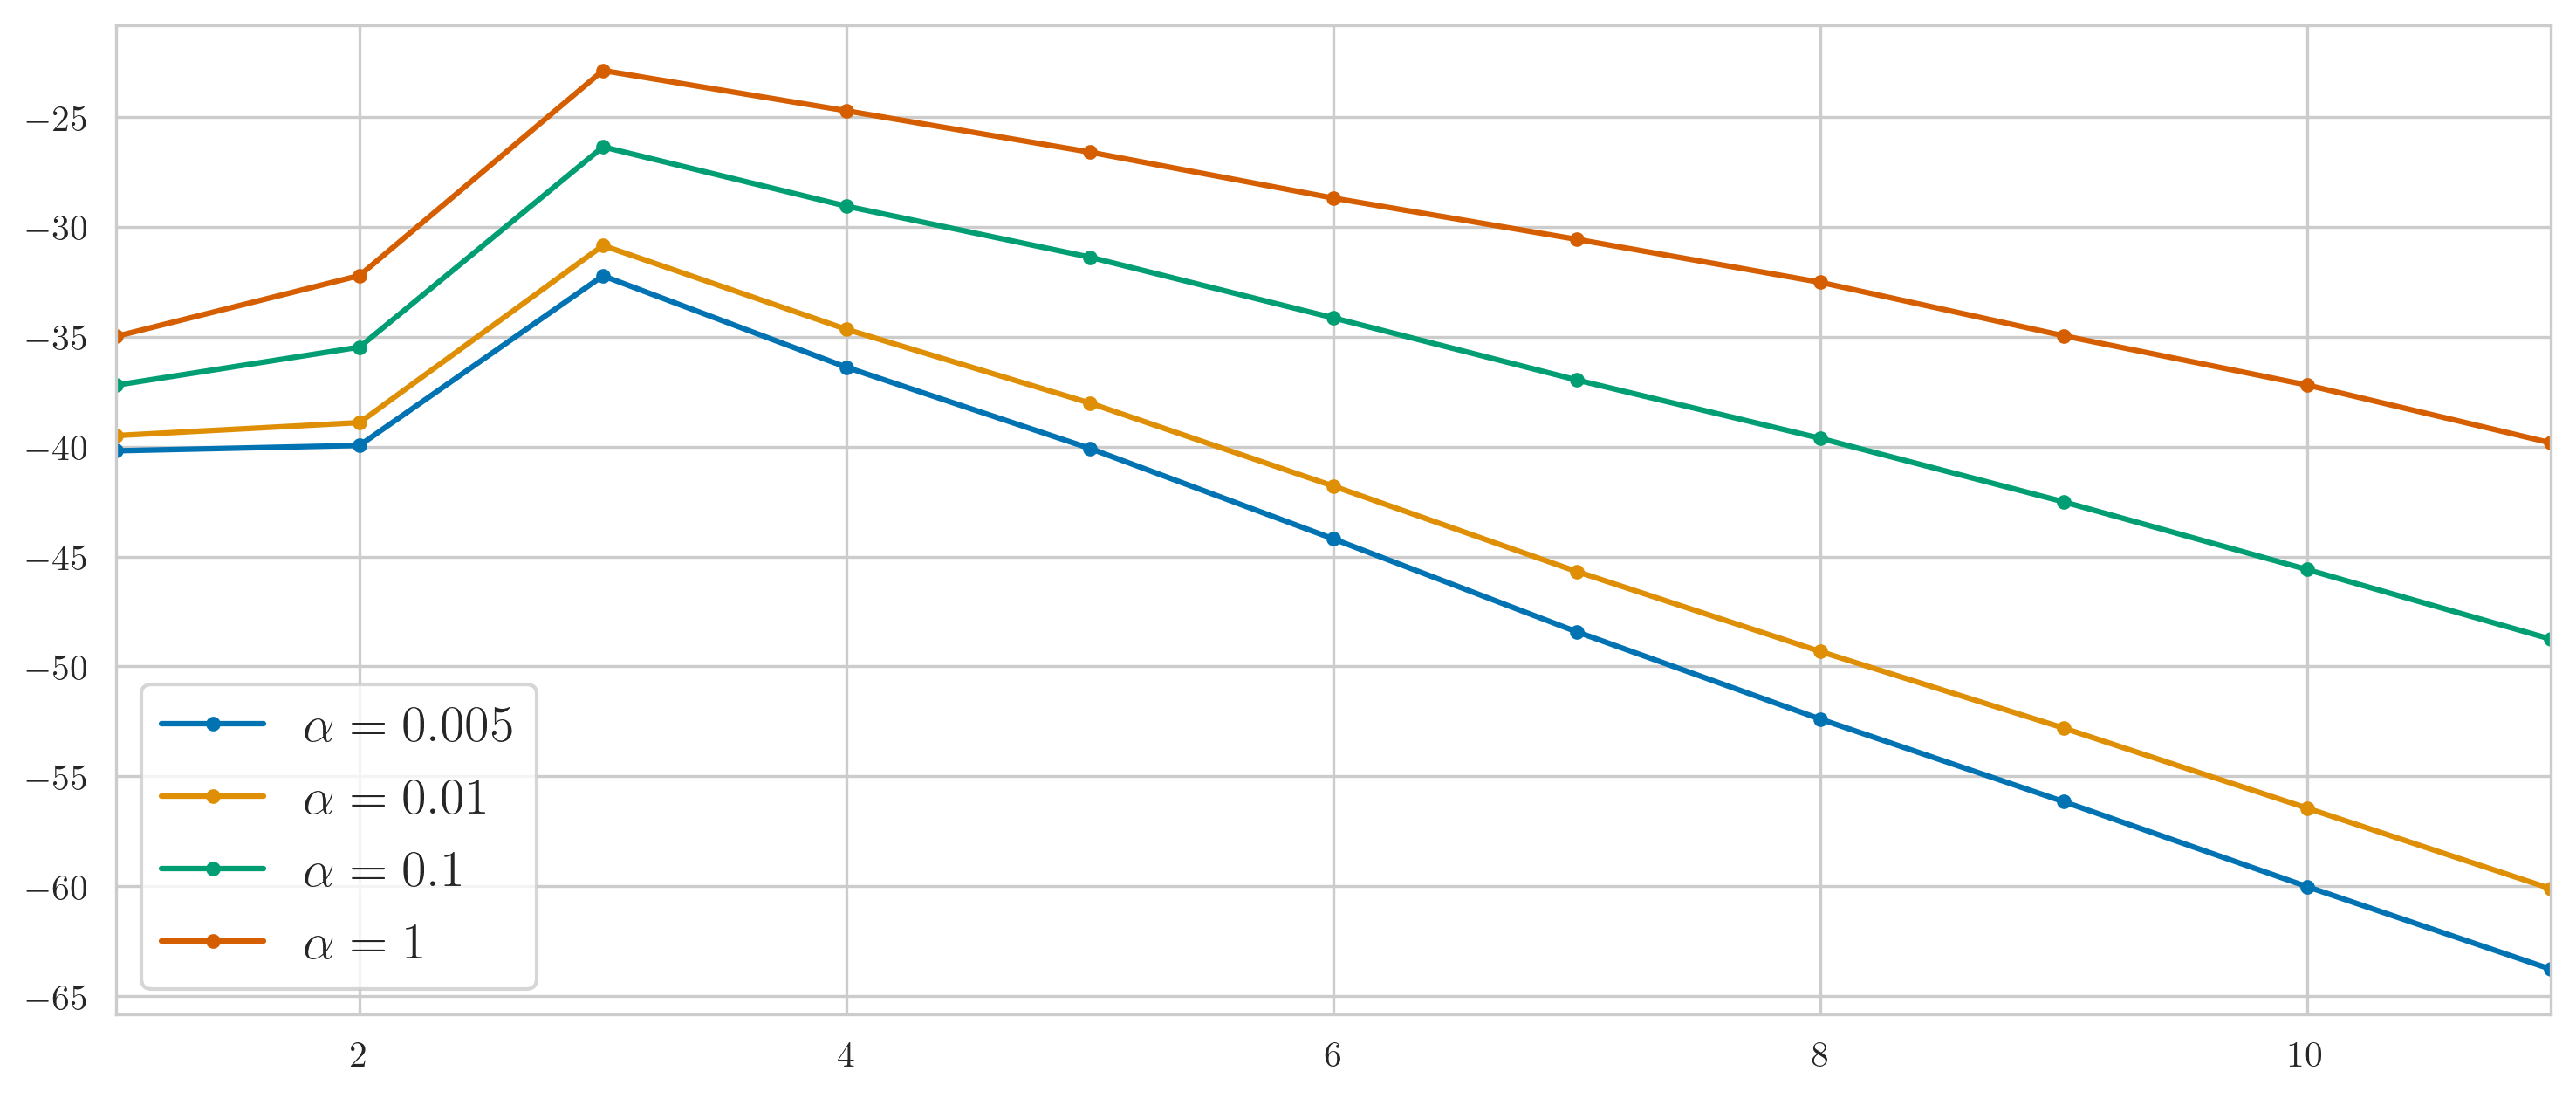

In [11]:
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(111)
ax.plot(range(1, 12), lr_evid, marker='.', label=r'$\alpha=0.005$')
ax.plot(range(1, 12), lr_evid2, marker='.', label=r'$\alpha=0.01$')
ax.plot(range(1, 12), lr_evid3, marker='.', label=r'$\alpha=0.1$')
ax.plot(range(1, 12), lr_evid4, marker='.', label=r'$\alpha=1$')
ax.set_xlim((1, 11))
ax.legend(fontsize=14)

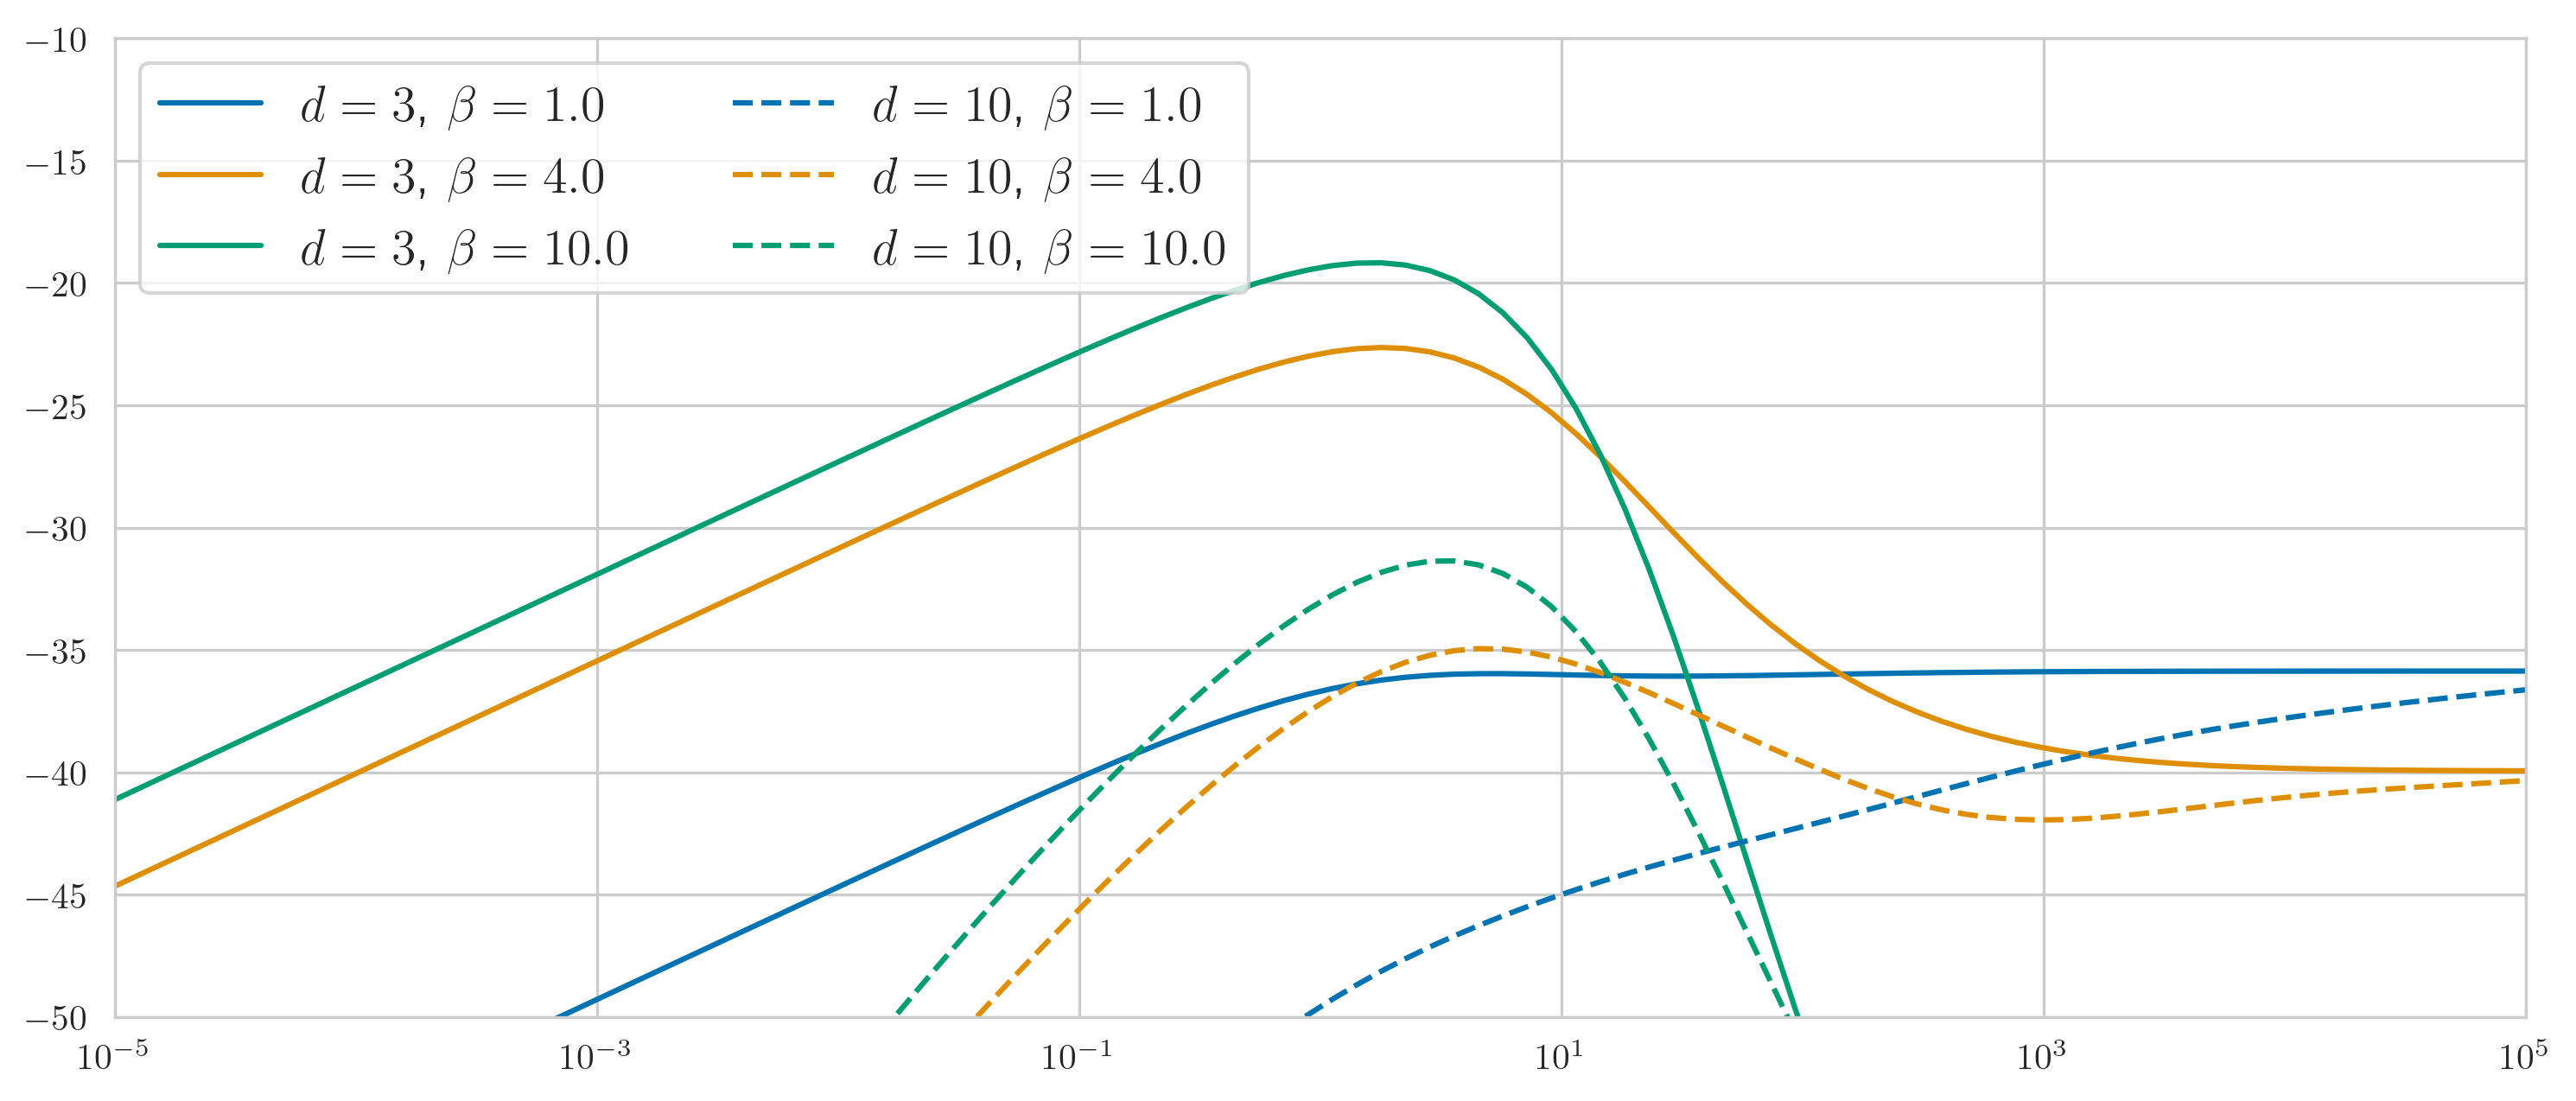

In [16]:
alphas = np.logspace(-5, 5, 100)

d_vals = [3, 10]
beta_vals = [1, 4, 10]

evids1 = dict()
for beta in beta_vals:
    evids1[beta] = [lr_log_marginal(xd_d, data, d_vals[0], alpha=a, beta=beta) for a in alphas]

evids2 = dict()
for beta in beta_vals:
    evids2[beta] = [lr_log_marginal(xd_d, data, d_vals[1], alpha=a, beta=beta) for a in alphas]

fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(111)
ax.set_xscale('log')
for i, beta in enumerate(evids1.keys()):
    ax.plot(alphas, evids1[beta], label=r'$d=%d$, $\beta=%.1f$' % (d_vals[0], beta))
for i, beta in enumerate(evids2.keys()):
    ax.plot(alphas, evids2[beta], label=r'$d=%d$, $\beta=%.1f$' % (d_vals[1], beta), c=sns_colors[i], linestyle='--')
ax.set_xlim((10**(-5), 10**5))
ax.set_ylim((-50, -10))
ax.legend(fontsize=14, ncol=2)

In [17]:
def empirical_iteration(X, t, XtX, XtT, lambdas, alpha, beta):
    N, d = X.shape
    cur_lambdas = beta * lambdas
    gamma = np.sum(cur_lambdas / (alpha + cur_lambdas))
    A = beta * XtX + alpha * np.identity(d)
    mu = beta * np.linalg.inv(A).dot(XtT)
    a = gamma / np.sum(mu ** 2)
    b = (N - gamma) / np.sum( (t - X.dot(mu)) ** 2)
    return a, b

In [18]:
def fit_eb(X, t, max_iter=400, eps=0.0001):
    XtX = X.T.dot(X)
    XtT = X.T.dot(t)
    lambdas = np.linalg.eigvalsh(XtX)
    alpha_0, beta_0 = 1, 1
    alpha, beta = [alpha_0], [beta_0]
    logmargs = [log_marginal_likelihood(X, t, alpha=alpha_0, beta=beta_0)]
    for _ in range(max_iter):
        a, b = empirical_iteration(X, t, XtX, XtT, lambdas, alpha[-1], beta[-1])
        alpha.append(a)
        beta.append(b)
        logmargs.append(log_marginal_likelihood(X, t, alpha=a, beta=b))
        if np.isclose(alpha[-1], alpha[-2], eps) and np.isclose(beta[-1], beta[-2], eps):
            break
    return alpha, beta, logmargs

In [19]:
alphas, betas, lms = fit_eb(get_X(3), data)
alphas2, betas2, lms2 = fit_eb(get_X(10), data)

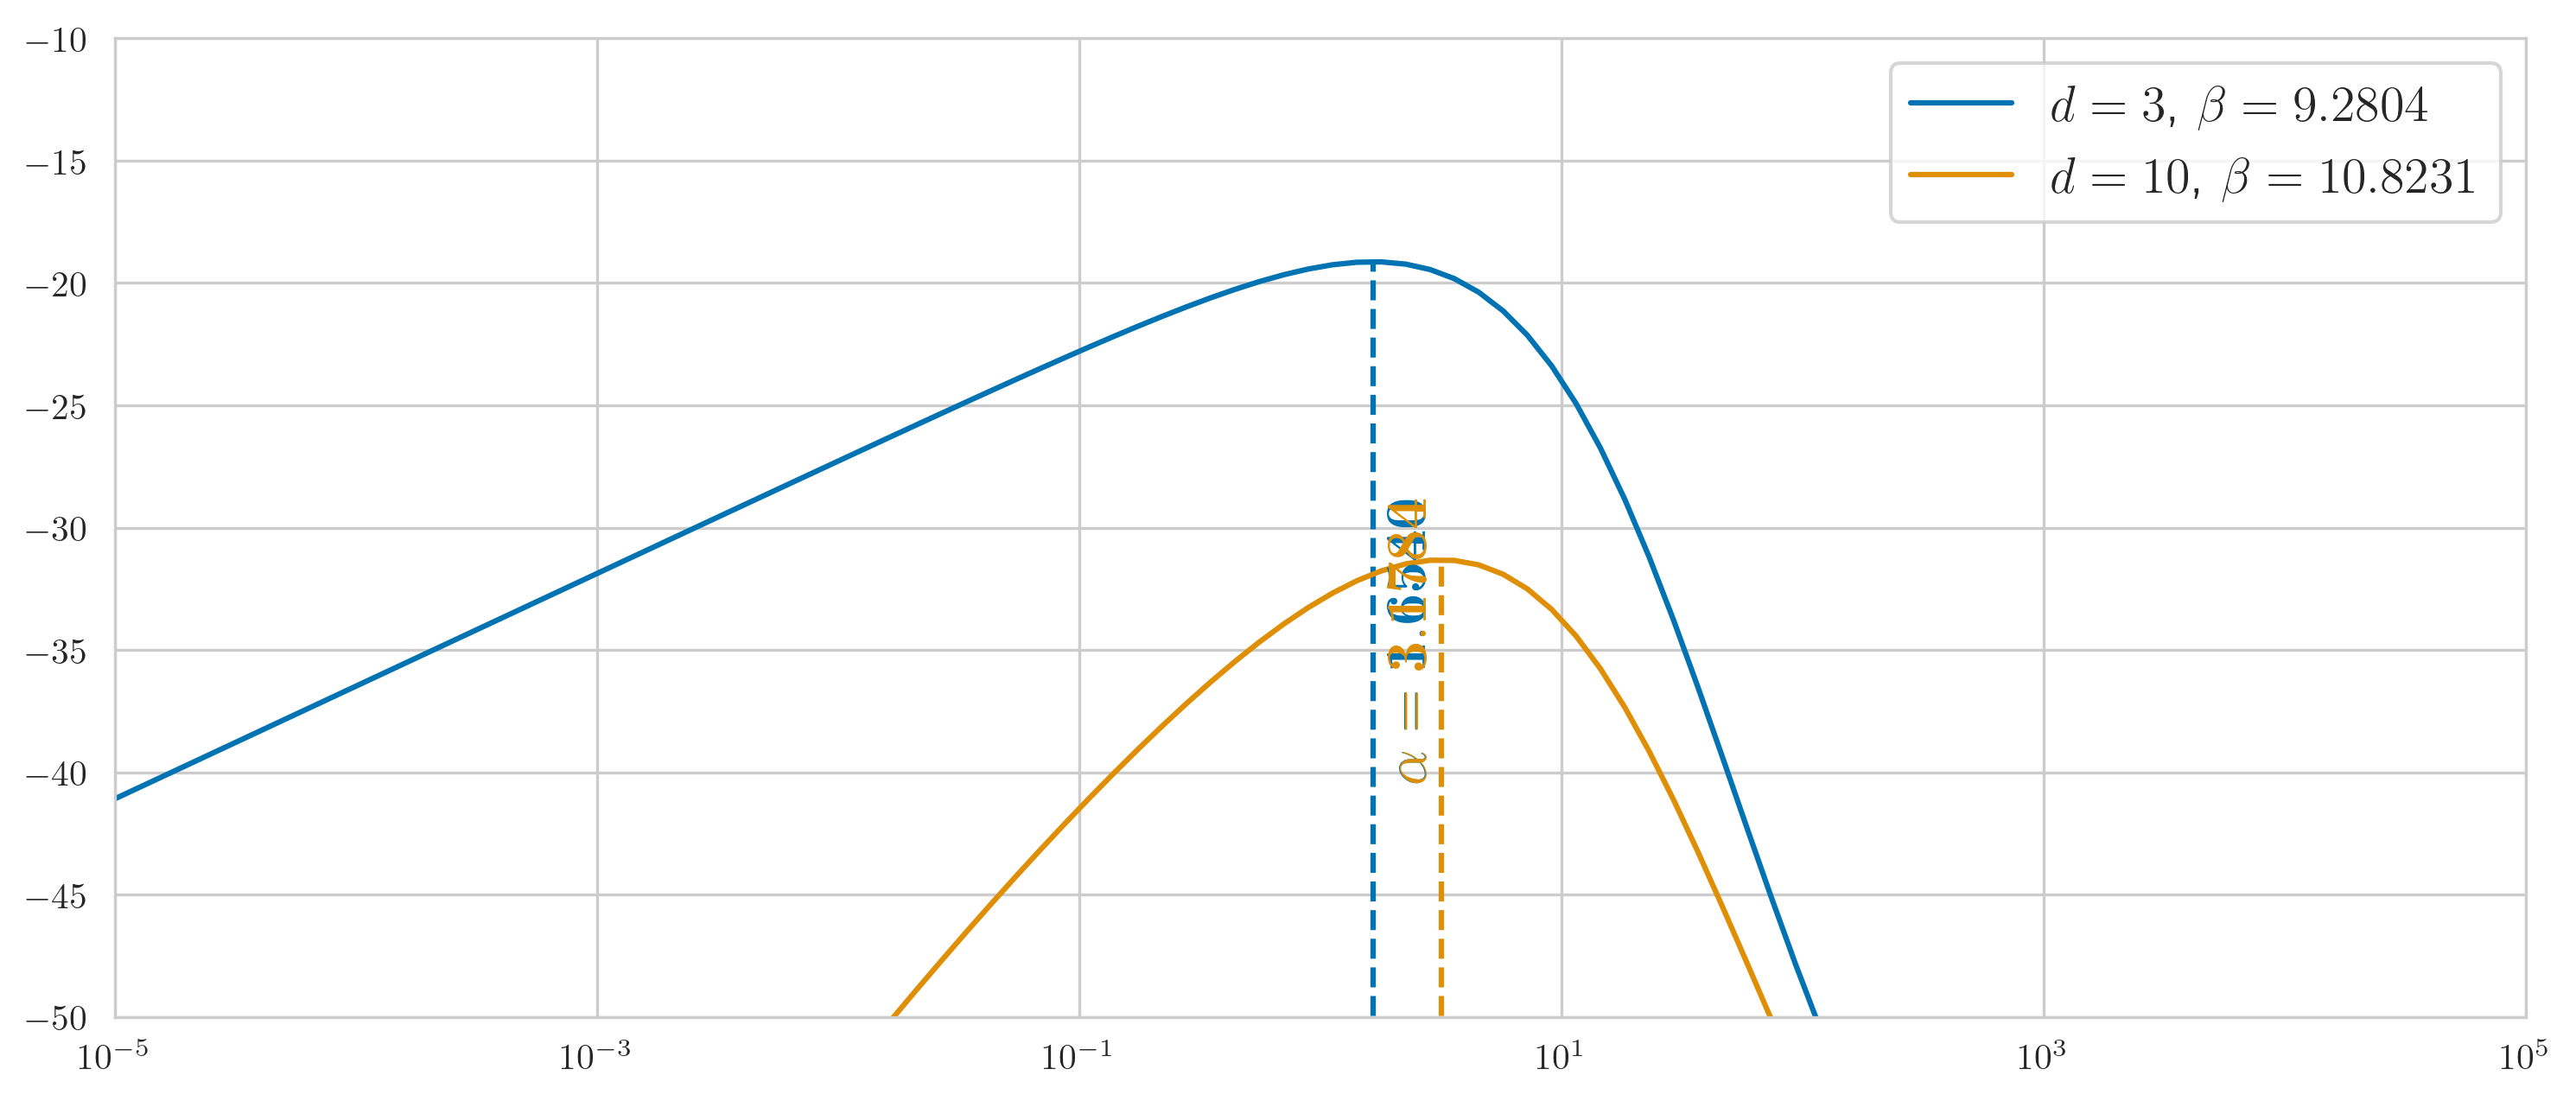

In [20]:
aas = np.logspace(-5, 5, 100)

evids = [lr_log_marginal(xd_d, data, 3, alpha=a, beta=betas[-1]) for a in aas]
evids2 = [lr_log_marginal(xd_d, data, 10, alpha=a, beta=betas2[-1]) for a in aas]

fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(111)
ax.set_xscale('log')
ax.plot(aas, evids, label=r'$d=3$, $\beta=%.4f$' % betas[-1])
ax.vlines(alphas[-1], -70, lr_log_marginal(xd_d, data, 3, alpha=alphas[-1], beta=betas[-1]), linestyles='--')
ax.text(alphas[-1]+.2, -40, r'$\mathbf{\alpha=%.4f}$' % alphas[-1], rotation=90, fontsize=16, color=sns_colors[0], horizontalalignment='left')
ax.plot(aas, evids2, label=r'$d=10$, $\beta=%.4f$' % betas2[-1])
ax.vlines(alphas2[-1], -70, lr_log_marginal(xd_d, data, 10, alpha=alphas2[-1], beta=betas2[-1]), linestyles='--', colors=sns_colors[1])
ax.text(alphas2[-1]-.1, -40, r'$\mathbf{\alpha=%.4f}$' % alphas2[-1], rotation=90, fontsize=16, color=sns_colors[1], horizontalalignment='right')
ax.set_xlim((10**(-5), 10**5))
ax.set_ylim((-50, -10))
ax.legend(fontsize=14)